## ElasticFDSG 3D Demo

This script showcases how to setup, run and visualize results of a 3D simulation. 

For demonstration purposes, we will restrict ourself to a simply layered velocity model.

#### Content

- Create velocity model file 

- Create configuration file 

- Run simulation 

- Load results 

- Visualize results

In [11]:
# Import dependencies
using ElasticFDSG 

# To use a GPU-backend, import it to the Main namespace:
using Metal # CUDA, AMDGPU, oneAPI 

using JLD2, YAML  # read and write 
using GLMakie     # visualization 
Makie.inline!(true) 

# Set some paths
VELMODPATH = joinpath(@__DIR__, "velmod.jld2")
CONFIGPATH = joinpath(@__DIR__, "config.yaml")
RESULTPATH = joinpath(@__DIR__, "results")
RESULTFILE = RESULTPATH * ".h5";

### Create velocity model file

In [12]:
function make_3d_layered_model(x_coords, y_coords, z_coords, v_layers; layer_depths=nothing)
    nx, ny, nz = length(x_coords), length(y_coords), length(z_coords)
    velocity = zeros(Float32, nx, ny, nz)
    n_layers = length(v_layers)
    if layer_depths === nothing
        layer_bounds = round.(Int, LinRange(1, nz+1, n_layers+1))
    else
        layer_bounds = [searchsortedfirst(z_coords, d) for d in layer_depths]
        push!(layer_bounds, nz+1)
    end
    for l in 1:n_layers
        z_start = layer_bounds[l]
        z_end   = layer_bounds[l+1]-1
        velocity[:, :, z_start:z_end] .= v_layers[l]
    end
    return velocity
end;

# spatial extends (y coords thin to make computations faster)
h = 5
xcoords = 0:h:1000 # x-coordinates
ycoords = 0:h:200  # y-coordinates
zcoords = 0:h:1000 # z-coordinates
nx, ny, nz = length(xcoords), length(ycoords), length(zcoords)

# define layer elastic properties
layer_depths = [0, 100, 200, 300, 400, 500] 
vp_layers = [1700.0, 1850.0, 2000.0, 2250.0, 2500, 3500] 
vs_layers = vp_layers ./ sqrt(3) 
rho_layers = [1750, 1900.0, 2100.0, 2200.0, 2200.0, 2400.] 

# some vti-layers
eps1_layers = [0, 0, 0, 0, 0.2, 0.4];
eps2_layers = [0, 0, 0, 0, 0.2, 0.4];
gam1_layers = [0, 0, 0, 0, 0.1, 0.25];
gam2_layers = [0, 0, 0, 0, 0.1, 0.25];
del1_layers = [0, 0, 0, 0, 0.05, -0.1];
del2_layers = [0, 0, 0, 0, 0.05, -0.1];
del3_layers = [0, 0, 0, 0, 0, 0];

vp =    make_3d_layered_model(xcoords, ycoords, zcoords, vp_layers; layer_depths=layer_depths);
vs =    make_3d_layered_model(xcoords, ycoords, zcoords, vs_layers; layer_depths=layer_depths);
rho =   make_3d_layered_model(xcoords, ycoords, zcoords, rho_layers; layer_depths=layer_depths);
eps1 =  make_3d_layered_model(xcoords, ycoords, zcoords, eps1_layers; layer_depths=layer_depths);
eps2 =  make_3d_layered_model(xcoords, ycoords, zcoords, eps2_layers; layer_depths=layer_depths);
gam1 =  make_3d_layered_model(xcoords, ycoords, zcoords, gam1_layers; layer_depths=layer_depths);
gam2 =  make_3d_layered_model(xcoords, ycoords, zcoords, gam2_layers; layer_depths=layer_depths);
del1 =  make_3d_layered_model(xcoords, ycoords, zcoords, del1_layers; layer_depths=layer_depths);
del2 =  make_3d_layered_model(xcoords, ycoords, zcoords, del2_layers; layer_depths=layer_depths);
del3 =  make_3d_layered_model(xcoords, ycoords, zcoords, del3_layers; layer_depths=layer_depths);

# velocity model array
veldim = (13, nx, ny, nz)
velmod = zeros(veldim);

# meshgrid coordinates
X = getindex.(Iterators.product(xcoords, ycoords, zcoords), 1)
Y = getindex.(Iterators.product(xcoords, ycoords, zcoords), 2)
Z = getindex.(Iterators.product(xcoords, ycoords, zcoords), 3)

# fill with elastic properties
velmod[1,:,:,:] .= X
velmod[2,:,:,:] .= Y
velmod[3,:,:,:] .= Z

velmod[4,:,:,:] .= vp
velmod[5,:,:,:] .= vs
velmod[6,:,:,:] .= rho

velmod[7,:,:,:] .= eps1
velmod[8,:,:,:] .= eps2
velmod[9,:,:,:] .= gam1
velmod[10,:,:,:] .= gam2
velmod[11,:,:,:] .= del1
velmod[12,:,:,:] .= del2
velmod[13,:,:,:] .= del3

# save velocity model
jldsave(VELMODPATH; velmod)

### Create configuration file

Here, we create the file within the script.

Alternativly, one can use the 
```ElasticFDSG.config_template(path::String, dim::Real)``` function to create an empty .yaml file, which can be filled by hand afterwards.

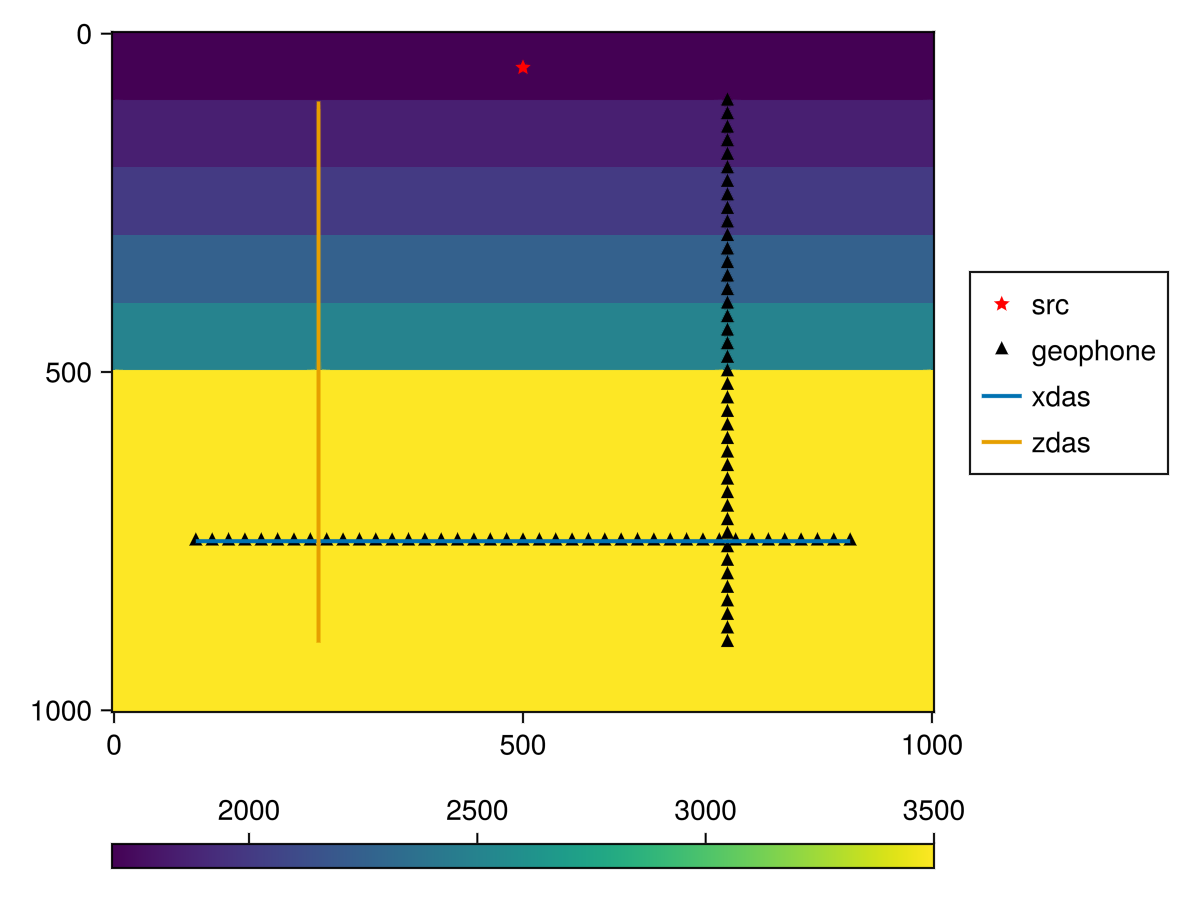

GLMakie.Screen(...)

In [13]:
function moment_tensor(δ, λ, Φ)
    """
    δ = Dip, λ = Rake, Φ = Strike
    Coordinate System: x -> north,
                       y -> east,
                       z -> positive downward
    """
    δ = deg2rad(δ)
    λ = deg2rad(λ)
    Φ = deg2rad(Φ)
  
    Mxx = -(sin(δ)*cos(λ)*sin(2*Φ) + sin(2*δ)*sin(λ)*sin(Φ)^2)
    Mxy = sin(δ)*cos(λ)*cos(2*Φ) + 1/2*sin(2*δ)*sin(λ)*sin(2*Φ)
    Mxz = -(cos(δ)*cos(λ)*cos(Φ) + cos(2*δ)*sin(λ)*sin(Φ))
    Myy = sin(δ)*cos(λ)*sin(2*Φ) - sin(2*δ)*sin(λ)*cos(Φ)^2
    Myz = -(cos(δ)*cos(λ)*sin(Φ) - cos(2*δ)*sin(λ)*cos(Φ))
    Mzz = sin(2*δ)*sin(λ)

    return Mxx, Mxy, Mxz, Myy, Myz, Mzz
end;

# source location
source_x = 500
source_y = 100 
source_z = 50

# lets define a horizontal and a vertical geophone array
horizontal_geo_array = [Dict("x"=>x, "y"=>100, "z"=>750) for x in 100:20:900]
vertical_geo_array   = [Dict("x"=>750, "y"=>100, "z"=>z) for z in 100:20:900]
# combine them into a single geophone 
geophones = vcat(horizontal_geo_array, vertical_geo_array)
# and save indices for later
harray_indices = 1:length(horizontal_geo_array)
varray_indices = length(horizontal_geo_array)+1:length(geophones)

# define DAS profiles accordingly to geophone arrays. 
das_x = [
    Dict(
        "x" => Dict("start"=>100, "step"=>5, "end"=>900),
        "y" => 100,
        "z" => 750
    ),
]

das_z = [
    Dict(
        "x" => 250,
        "y" => 100,
        "z" => Dict("start"=>100, "step"=>5, "end"=>900)
    ),
]


# a thrust fault 
dip = 30 
strike = 45
rake = 90 
Mxx, Mxy, Mxz, Myy, Myz, Mzz = moment_tensor(dip, rake, strike)

# configuration file
config = Dict(
    "settings" => Dict(
        "device" => "metal",                  # cpu / cuda / metal / amd / intel
        "precision" => "Float32",             # Float64 / Float32
        "spatial_derivative_order" => 4,      # 1-10
        "show_progress_in_console" => true,   # true / false
        "output_file" => RESULTPATH
    ),
    "time" => Dict(
        "start" => 0.0,
        "end" => 1,
        "timestep" => 0.5
    ),
    "source" => Dict(
        "dominant_frequency" => 30,
        "wavelet_type" => "ricker",          # ricker / gauss1d
        "wavelet_center" => 0.042,           # >= 1.25/dominant_frequency
        "location" => Dict(
            "x" => source_x,
            "y" => source_y,
            "z" => source_z
        ),
        "seismic_moment" => 1e15,
        # a double couple source
        "moment_tensor" => Dict(
            "Mxx" => Mxx,
            "Myy" => Myy,
            "Mzz" => Mzz,
            "Mxy" => Mxy,
            "Mxz" => Mxz,
            "Myz" => Myz,
            "anisotropic" => false
        )
    ),
    "boundaries" => Dict(
        "xstart" => "absorbing",
        "xend" => "absorbing",
        "ystart" => "absorbing",
        "yend" => "absorbing",
        "zstart" => "absorbing",
        "zend" => "absorbing",
        "pml_layer" => 10
    ),
    "receivers" => Dict(
        "geophones" => geophones,
        "das" => Dict(
            "x_aligned" => das_x,  
            "y_aligned" => [],  
            "z_aligned" => das_z  
        ),
        "snapshots" => Dict(
            "plane_positions" => [
                Dict("x" => 500, "y" => 100, "z" => 500),
            ],
            "times" => collect(0:0.1:1),           
            "fields" => ["vx", "vy", "vz"]  
        )
    )
)

# save config file
open(CONFIGPATH, "w") do file
    YAML.write(file, config)
end

# plot XZ-plane with source-receivers 
fig = Figure() 
ax = Axis(fig[1,1], yreversed=true)
img = heatmap!(ax, xcoords, zcoords, vp[:,10,:])
src = scatter!(ax, [source_x],[source_z],marker=:star5,color="red")
geo = scatter!(ax, [x["x"] for x in geophones],
                   [z["z"] for z in geophones],
                    marker=:utriangle, color=:black)
hdas = lines!(ax, 100:5:900, fill(750, length(100:5:900)), linewidth=2)
vdas = lines!(ax, fill(250, length(100:5:900)), 100:5:900, linewidth=2)
Colorbar(fig[2,1], img, vertical=false)
Legend(fig[1,2], [src, geo, hdas,vdas], ["src", "geophone", "xdas","zdas"])
display(fig)


### Run the simulation

In [14]:
ElasticFDSG.dim3.runsim(CONFIGPATH, VELMODPATH)

┌ Warning: Given Δt does not satisfy the CFL-stability criterion. Δt changed to 0.00033811759497610655.
└ @ nothing nothing:nothing


╔══════════════════════════════════════════════
║ FDSG 3D - Summary                   
╠══════════════════════════════════════════════
║ System: 
║   Device: Apple M2 Max                        
║   Approx. Memory: 0.39 GB       
║ Grid: 
║   x: 0.0: 5.0: 1000.0            
║   y: 0.0: 5.0: 200.0            
║   z: 0.0: 5.0: 1000.0            
║   Number of Nodes: 3618429               
║ Time: 
║   Interval: 0.0: 0.00034: 0.99981              
║   Number of Timesteps: 2958           
║ Source: 
║   x,y,z: 500.0, 100.0, 50.0            
║   fdom, t0: 30, 0.042           
║ Receiver: 
║   Number of Geophones: 82            
║   Number of Snapshots: 33       
║   Number of Fibers: 1, 0, 1            
╚══════════════════════════════════════════════


Progress: 100%|███████████████████████████| Time: 0:02:58 (60.49 ms/it)


Results saved.


### Load Results

In [15]:
# visualize data structure 
ElasticFDSG.print_h5_tree(RESULTFILE)
# load as dictionary 
results = ElasticFDSG.load_results(RESULTFILE);

********************************************************************
H5-File Tree
********************************************************************
└─ Group: das
   ├─ Group: x_aligned
   │  ├─ Group: fiber_1
   │  │  └─ Dataset: data  size=(161, 2958)  eltype=Float32
   │  │  └─ Dataset: location_xyz  size=(161, 3)  eltype=Float32
   ├─ Group: z_aligned
   │  └─ Group: fiber_1
   │     └─ Dataset: data  size=(161, 2958)  eltype=Float32
   │     └─ Dataset: location_xyz  size=(161, 3)  eltype=Float32
└─ Group: geophones
   ├─ Group: geophone_1
   │  ├─ Dataset: data  size=(3, 2958)  eltype=Float32
   │  ├─ Dataset: location_xyz  size=(3,)  eltype=Float32
   ├─ Group: geophone_10
   │  ├─ Dataset: data  size=(3, 2958)  eltype=Float32
   │  ├─ Dataset: location_xyz  size=(3,)  eltype=Float32
   ├─ Group: geophone_11
   │  ├─ Dataset: data  size=(3, 2958)  eltype=Float32
   │  ├─ Dataset: location_xyz  size=(3,)  eltype=Float32
   ├─ Group: geophone_12
   │  ├─ Dataset: data  size=(3, 

### Visualize

- Snapshots

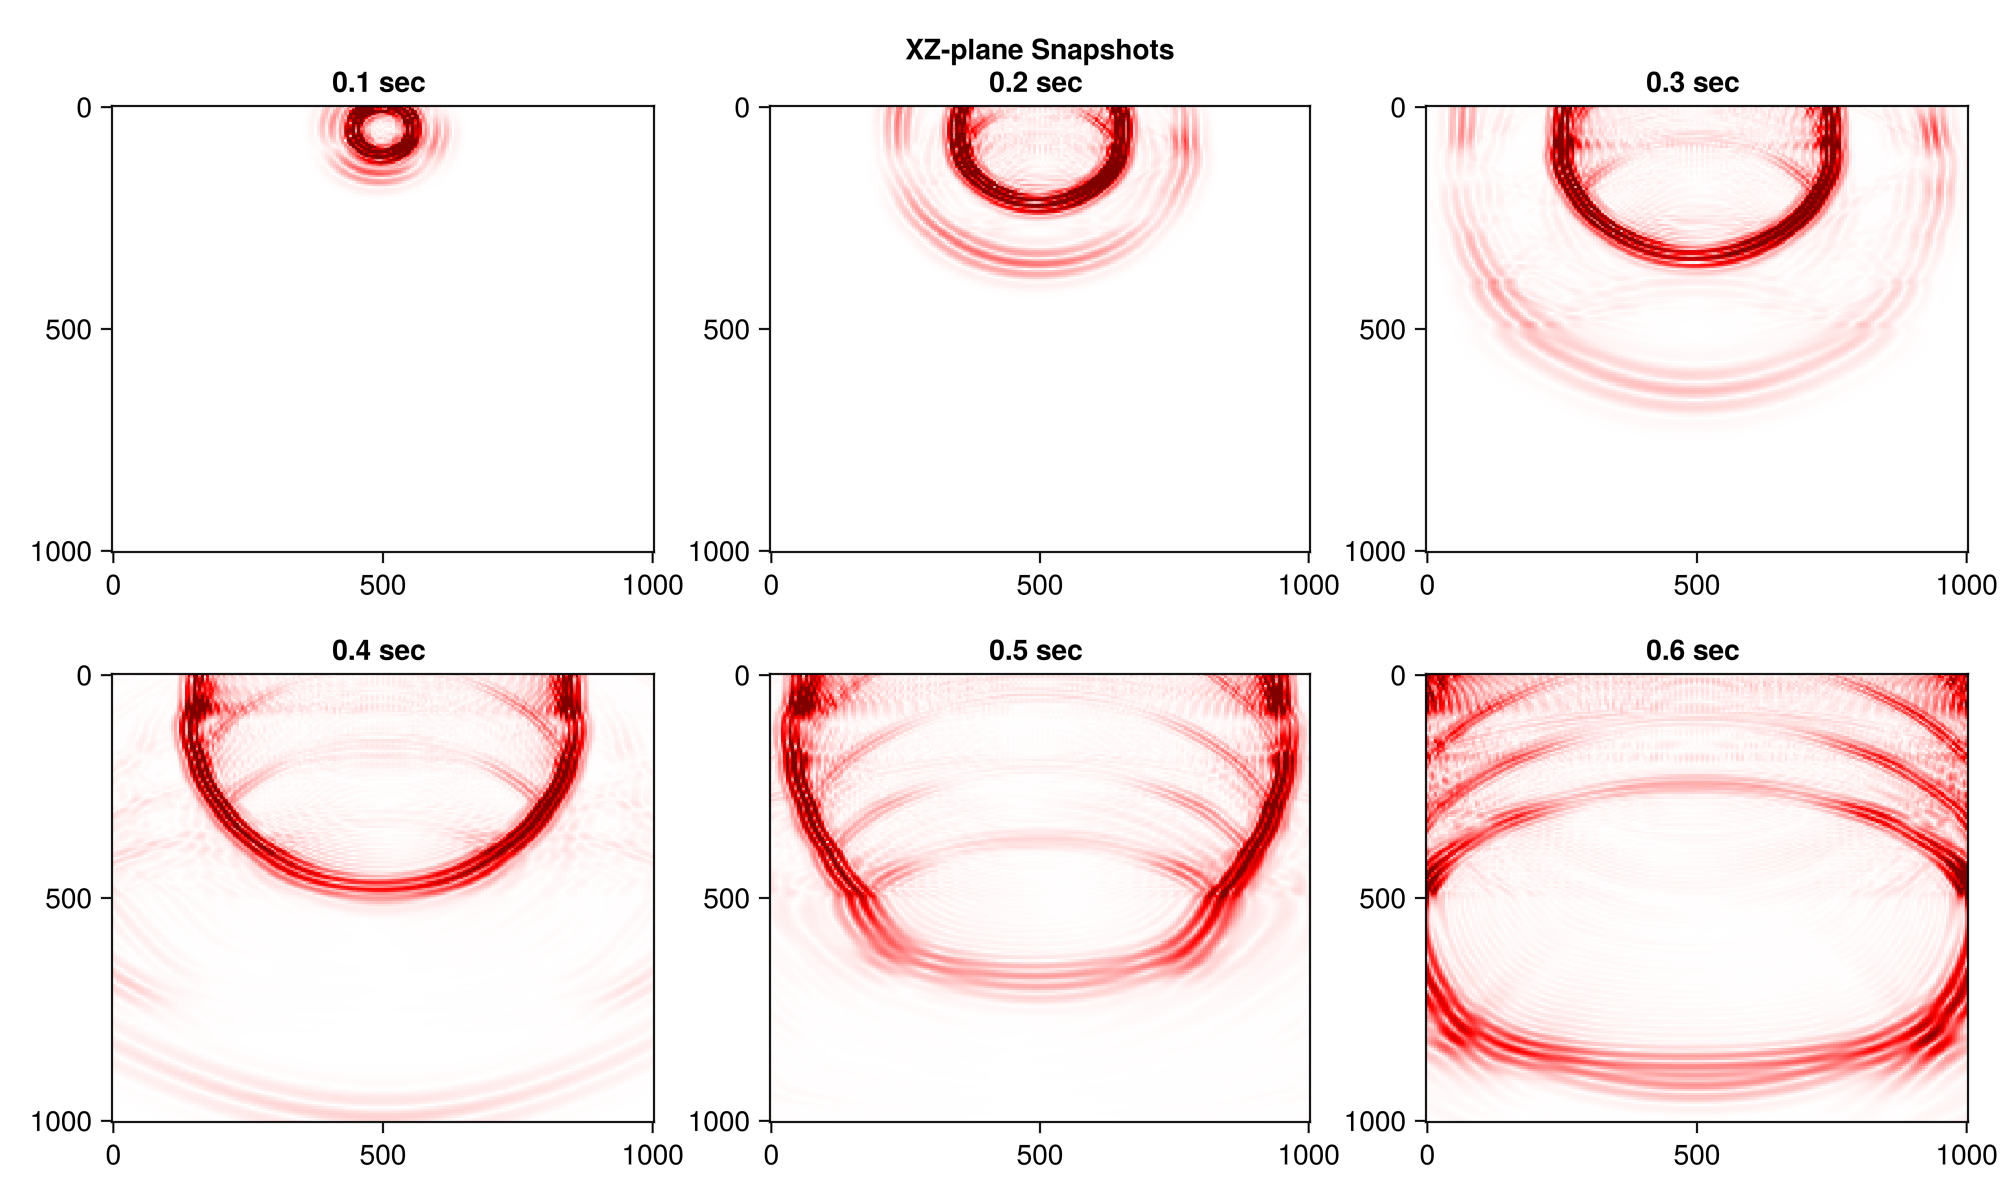

GLMakie.Screen(...)

In [16]:
time = results["time"]["time"]
snapshots = results["snapshots"]
geophones = results["geophones"]
das = results["das"]

plane_index = 1
snaps_t = snapshots["times"]
snaps_XZ = snapshots["data_$(plane_index)"]["XZ_data"]
time_ids = [2 3 4; 5 6 7]

fig = Figure(size=(1000,600))
for i in 1:2, j in 1:3
    time_id = time_ids[i,j]
    t = snaps_t[time_id]

    xz = snaps_XZ[time_id, :, :, :]
    # xy[1]->vx, xy[2]->vy, xy[1]->vz
    ekin = @. 0.5 * sqrt(xz[1,:,:]^2 + xz[2,:,:]^2 + xz[3,:,:]^2)
    col = maximum(ekin) / 3
    title = i == 1 && j == 2 ? "XZ-plane Snapshots\n" : ""

    ax = Axis(fig[i,j], title=title*"$(t) sec ", yreversed=true)
    heatmap!(ax, xcoords, zcoords, ekin, colorrange=(-col,col), colormap="seismic")
    
end
display(fig)


- Geophones

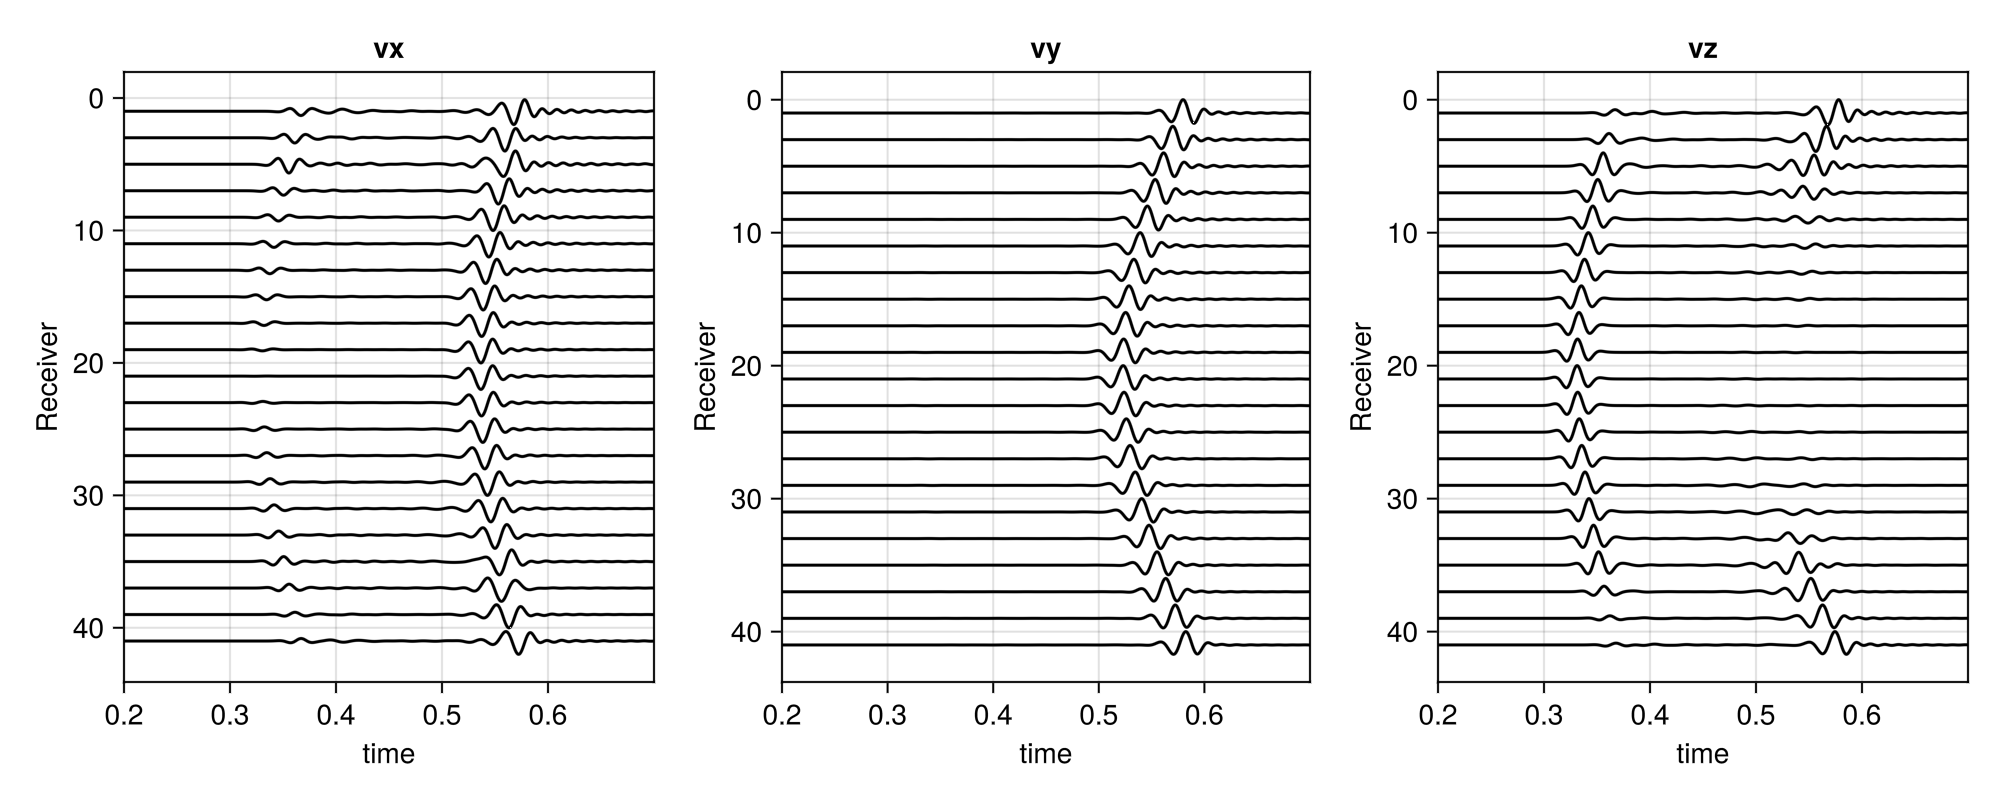

GLMakie.Screen(...)

In [17]:
# horizontal array 
function norm11(arr)
    res = arr ./ maximum(abs, arr)
    return res 
end;

fig = Figure(size=(1000, 400)) 
ax1 = Axis(fig[1,1], yreversed=true,title="vx",xlabel="time",ylabel="Receiver")
ax2 = Axis(fig[1,2], yreversed=true,title="vy",xlabel="time",ylabel="Receiver")
ax3 = Axis(fig[1,3], yreversed=true,title="vz",xlabel="time",ylabel="Receiver")

for hidx in harray_indices[begin:2:end]
    geo_data = geophones["geophone_$(hidx)"]["data"]
    
    lines!(ax1, time, norm11(geo_data[1,:]) .+ hidx, color="black")
    lines!(ax2, time, norm11(geo_data[2,:]) .+ hidx, color="black")
    lines!(ax3, time, norm11(geo_data[3,:]) .+ hidx, color="black")
end   

xlims!(ax1, 0.2, 0.7)
xlims!(ax2, 0.2, 0.7)
xlims!(ax3, 0.2, 0.7)

display(fig)

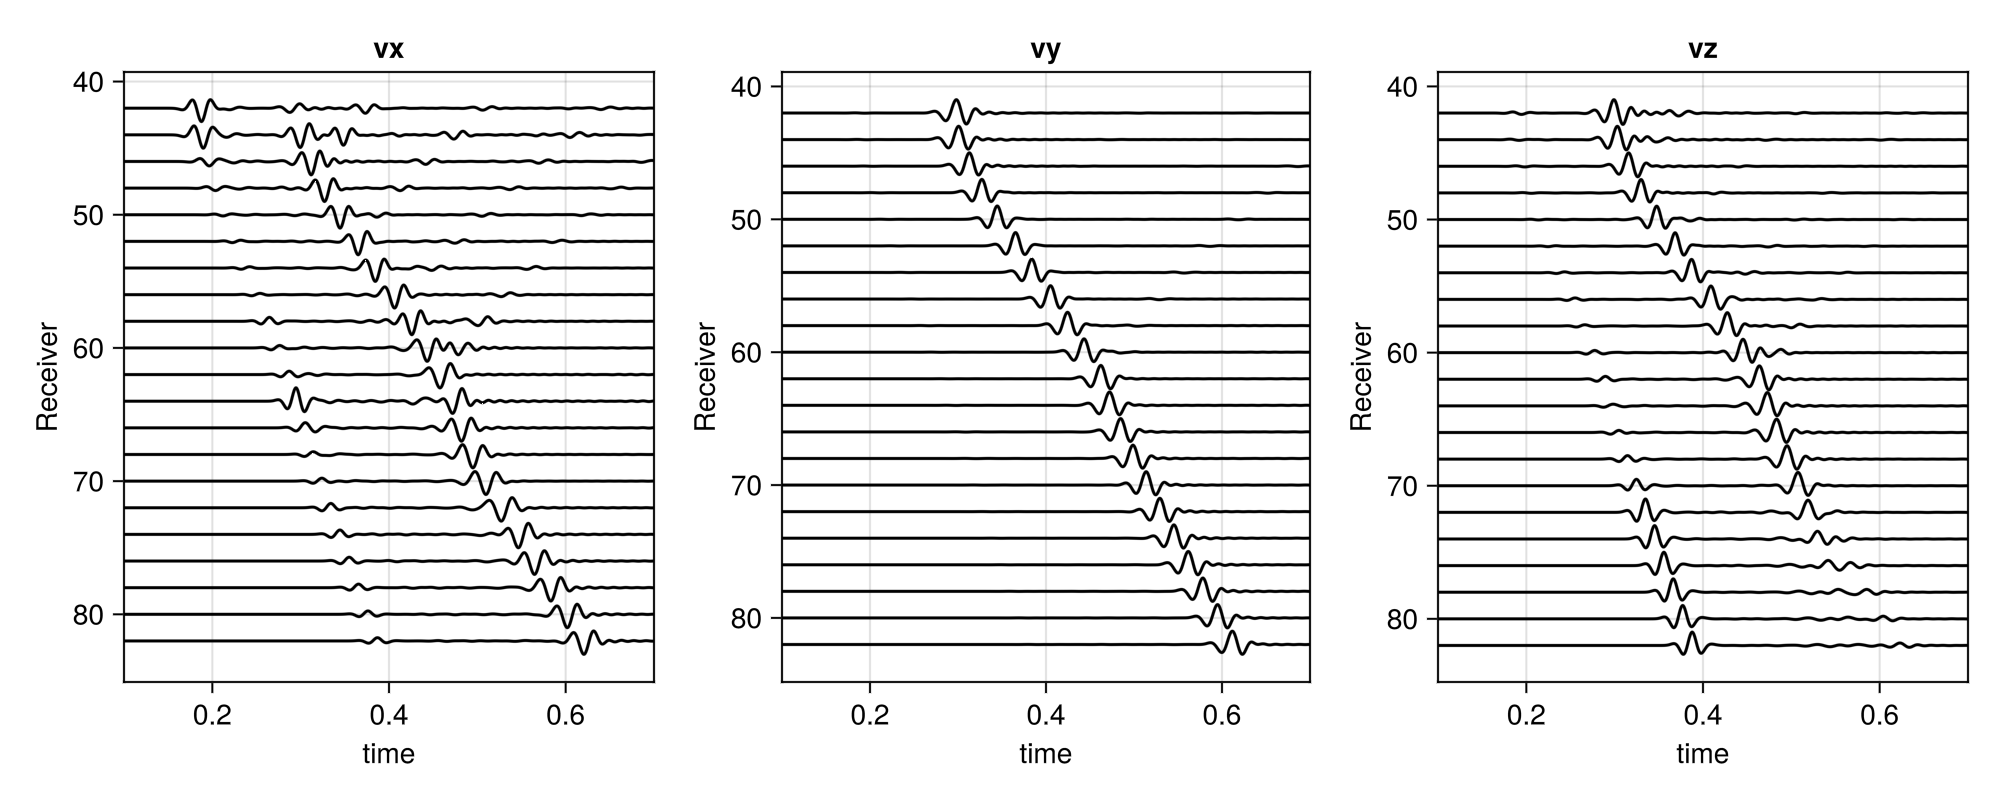

GLMakie.Screen(...)

In [18]:
# vertical array 
fig = Figure(size=(1000, 400)) 
ax1 = Axis(fig[1,1], yreversed=true,title="vx",xlabel="time",ylabel="Receiver")
ax2 = Axis(fig[1,2], yreversed=true,title="vy",xlabel="time",ylabel="Receiver")
ax3 = Axis(fig[1,3], yreversed=true,title="vz",xlabel="time",ylabel="Receiver")

for vidx in varray_indices[begin:2:end]
    geo_data = geophones["geophone_$(vidx)"]["data"]
    
    lines!(ax1, time, norm11(geo_data[1,:]) .+ vidx, color="black")
    lines!(ax2, time, norm11(geo_data[2,:]) .+ vidx, color="black")
    lines!(ax3, time, norm11(geo_data[3,:]) .+ vidx, color="black")
end   

xlims!(ax1, 0.1, 0.7)
xlims!(ax2, 0.1, 0.7)
xlims!(ax3, 0.1, 0.7)

display(fig)

- DAS

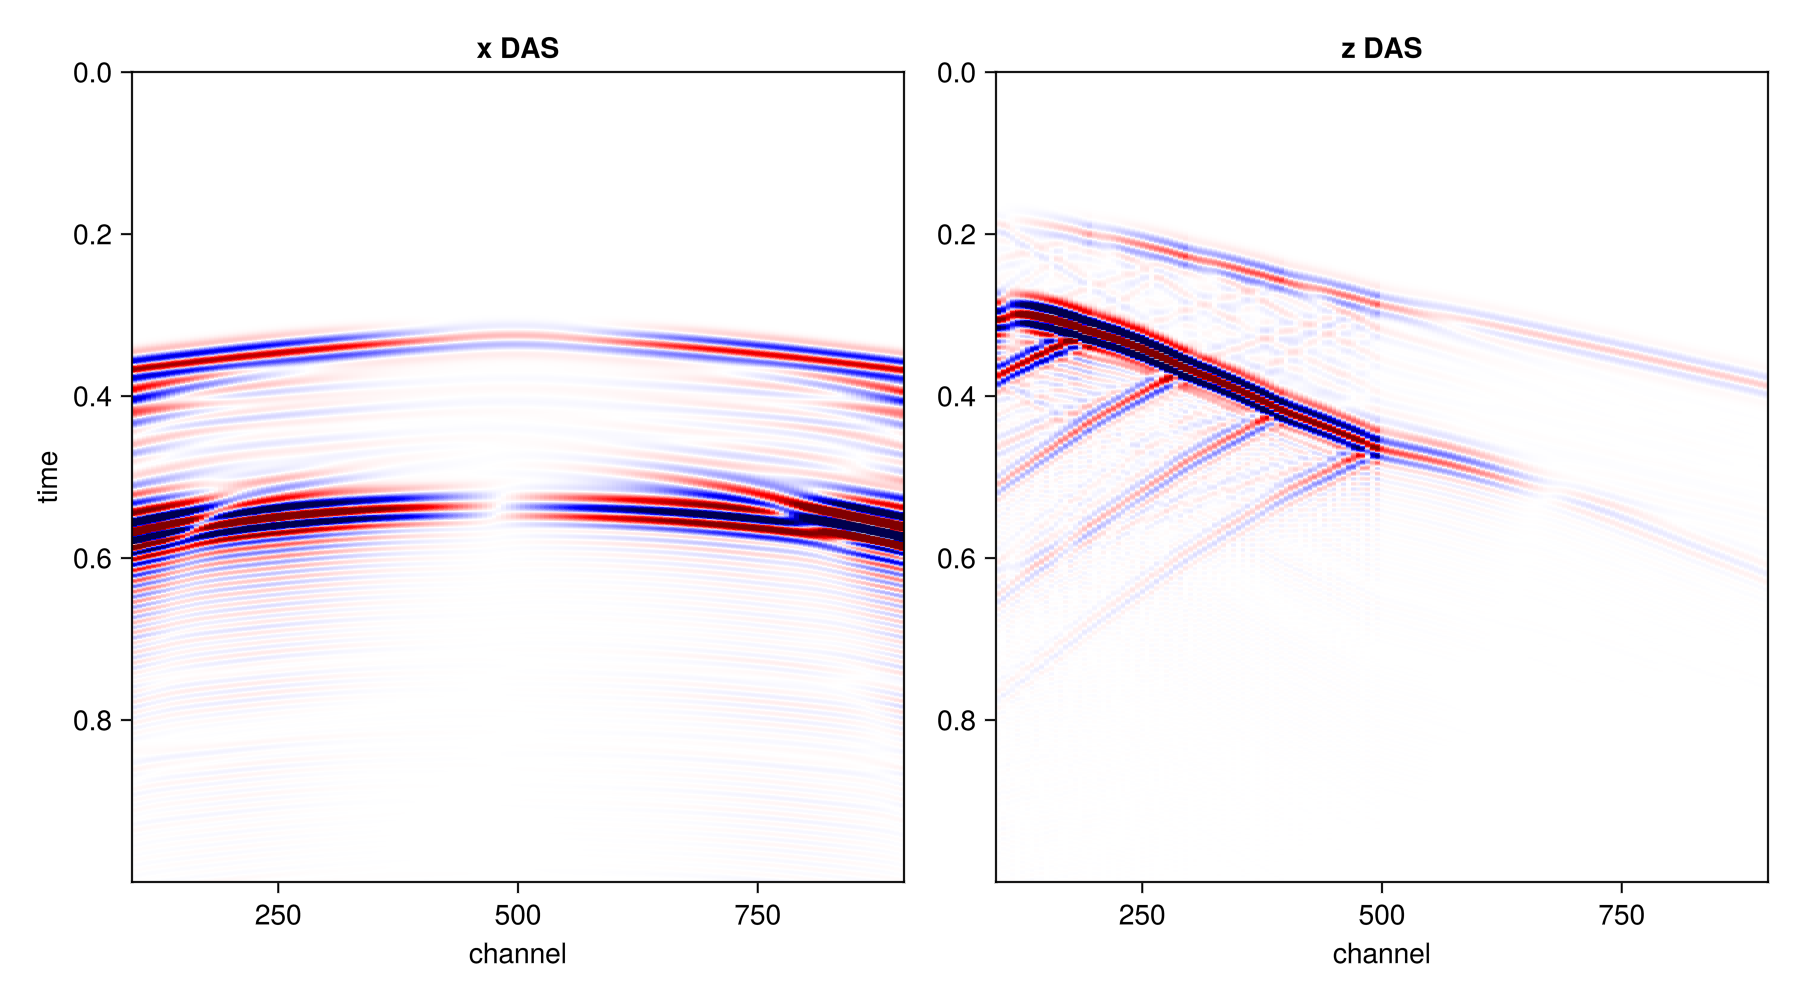

In [19]:
fig = Figure(size=(900,500)) 

ax1 = Axis(fig[1,1], yreversed=true, xlabel="channel", ylabel="time", title="x DAS")
ax2 = Axis(fig[1,2], yreversed=true, xlabel="channel", title="z DAS")

x = das["x_aligned"]["fiber_1"]["data"]
z = das["z_aligned"]["fiber_1"]["data"]

xcol = maximum(x) / 5 
zcol = maximum(z) / 5 

heatmap!(ax1, 100:5:900, time, x, colorrange=(-xcol,xcol), colormap="seismic")
heatmap!(ax2, 100:5:900, time, z, colorrange=(-zcol,zcol), colormap="seismic")
display(fig)

# to keep the repository clean, delete all files.
rm(CONFIGPATH)
rm(VELMODPATH)
rm(RESULTFILE)